# Podcast Reviews Dataset Analysis

**Summary**:

The analysis performed on the podcast data provided insights into various aspects such as the distribution of ratings, frequency of reviews over time, top podcasts by review count and average rating, top categories by review count and average rating, and sentiment analysis of top podcasts by number of reviews.

Three hypotheses were tested:

- Podcasts with a higher frequency of reviews tend to have more positive sentiment polarity.
- The distribution of ratings for podcasts changes over time, with newer podcasts receiving higher initial ratings.
- The most popular categories by review count will also have a higher average sentiment polarity compared to less popular categories.


### Importing necessary libraries

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Connect to the SQLite database

In [3]:
conn = sqlite3.connect(r"C:\Users\kresi\Downloads\database.sqlite\database.sqlite")

### Common Table Expression (CTE) to aggregate categories for each podcast

In [4]:
category_aggregation_query = """
WITH PodcastCategories AS (
    SELECT podcast_id,
           GROUP_CONCAT(category, '; ') AS all_categories
    FROM categories
    GROUP BY podcast_id
)
"""

### Joining the aggregated categories with podcasts and reviews
(*this query avoids duplicates by using the aggregated categories*)

In [5]:
query_1 = category_aggregation_query + """
SELECT p.title AS podcast_title,
       pc.all_categories,
       r.title AS review_title,
       r.content,
       r.rating,
       r.created_at
FROM podcasts p
JOIN PodcastCategories pc ON p.podcast_id = pc.podcast_id
JOIN reviews r ON p.podcast_id = r.podcast_id;
"""

joined_df = pd.read_sql_query(query_1, conn)

### Analyzing Categories: Number of reviews per category

In [6]:
query_2 = """
SELECT c.category,
       COUNT(r.podcast_id) AS review_count
FROM categories c
JOIN reviews r ON c.podcast_id = r.podcast_id
GROUP BY c.category;
"""

numrevcat_df = pd.read_sql_query(query_2, conn)

### Analyzing Ratings: Average rating per category

In [7]:
query_3 = """
SELECT c.category,
       AVG(r.rating) AS average_rating
FROM categories c
JOIN reviews r ON c.podcast_id = r.podcast_id
GROUP BY c.category;
"""

avgratcat_df = pd.read_sql_query(query_3, conn)

conn.close()

### Printing the sample of joined tables dataframe **joined_df_sample**

In [13]:
joined_df_sample = joined_df.sample(100).reset_index(drop=True)
joined_df_sample

,podcast_title,all_categories,review_title,content,rating,created_at
0,The Holderness Family Podcast,kids-family; kids-family-parenting; society-cu...,Relatable,I absolutely love your take on marriage and li...,5,2019-09-11 00:37:25-07:00
1,Locked On Capitals - Daily Podcast On The Wash...,sports; sports-hockey,:(,Pretty much completely unlistenable for techni...,2,2020-07-28 15:26:51-07:00
2,Mind Body No Soul,education; education-self-improvement; health-...,The Self Help Podcast we all Need,This podcast has already cured my toxic positi...,5,2021-04-05 08:38:06-07:00
3,Odessa,education; society-culture; society-culture-do...,Worth the wait,I waited a long time for these episodes but I’...,5,2021-05-14 17:02:52-07:00
4,The Sharyl Attkisson Podcast,news; news-politics,Great reporting,Sharyl Attkisson is a wonderful reporter as sh...,5,2021-02-13 05:42:59-07:00
...,...,...,...,...,...,...
95,Exposing PseudoAstronomy,science; science-natural-sciences,Always a great podcast,This podcast is really good and very consisten...,5,2012-12-29 16:01:13-07:00
96,Crime in Sports,comedy,great,following instructions,5,2019-08-13 19:34:15-07:00
97,Girls Gotta Eat,comedy; health-fitness; health-fitness-sexuality,❤️❤️❤️,Love love love everything about this podcast❤️,5,2020-06-07 20:44:57-07:00
98,The Art of Likability,business-careers,Thought provoking,Great podcast! Short enough to listen on to Qu...,5,2015-05-22 04:46:52-07:00


### Printing the dataframe of number of reviews per category **numrevcat_df**

In [11]:
numrevcat_df

,category,review_count
0,arts,136508
1,arts-books,30613
2,arts-design,9431
3,arts-fashion-beauty,14945
4,arts-food,16556
...,...,...
105,tv-film-after-shows,27184
106,tv-film-film-history,6173
107,tv-film-film-interviews,6011
108,tv-film-film-reviews,22556


### Printing the dataframe of average rating per category **avgratcat_df**

In [12]:
avgratcat_df

,category,average_rating
0,arts,4.727782
1,arts-books,4.681933
2,arts-design,4.811367
3,arts-fashion-beauty,4.649716
4,arts-food,4.781107
...,...,...
105,tv-film-after-shows,4.391995
106,tv-film-film-history,4.671959
107,tv-film-film-interviews,4.773748
108,tv-film-film-reviews,4.752084


### Converting 'created_at' feature to datetime, coercing errors to NaT

In [12]:
joined_df['created_at'] = pd.to_datetime(joined_df['created_at'], errors='coerce')

### Plotting the distribution of ratings

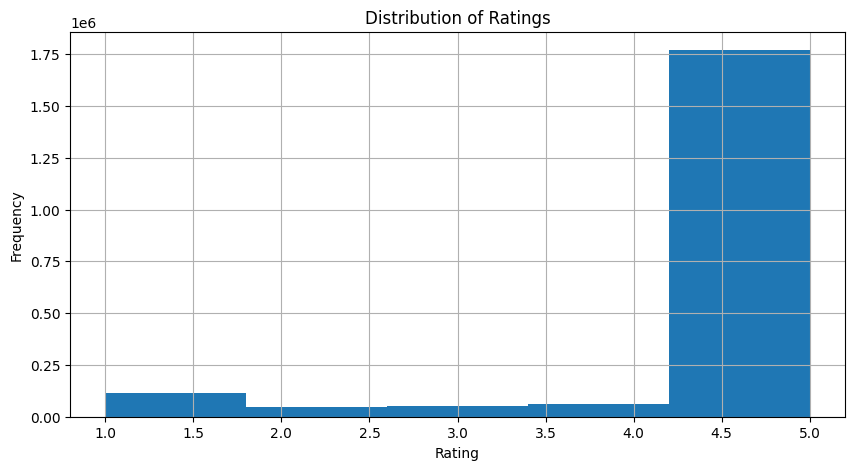

In [14]:
plt.figure(figsize=(10, 5))
joined_df['rating'].hist(bins=5)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Majority of podcasts are rated in a range 4.2 to 5

### Plotting the frequency of reviews over time

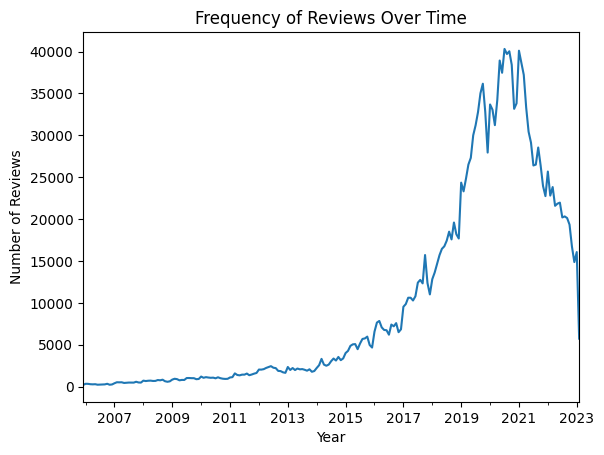

In [15]:
joined_df.set_index('created_at').resample('ME')['rating'].count().plot()
plt.title('Frequency of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

During 2020 and 2021 there is a significant peak of number of reviews (maybe due to pandemic lockdown).

### Grouping by 'podcast_title' and calculating the average rating and review count and sorting by 'review_count' and 'average_rating' to find the top podcasts

In [8]:
podcast_metrics = joined_df.groupby('podcast_title').agg({
    'rating': ['mean', 'count']
}).reset_index()

podcast_metrics.columns = ['podcast_title', 'average_rating', 'review_count']

top_podcasts = podcast_metrics.sort_values(by=['review_count', 'average_rating'], ascending=False).head(10)

In [9]:
podcast_metrics

,podcast_title,average_rating,review_count
0,! Weird Rap Podcast !,5.000000,14
1,!Please Remain Calm!,5.000000,13
2,"""Artists Behind the Action""",5.000000,4
3,"""Built to Scale"" eCommerce Show",5.000000,16
4,"""DOPE AS USUAL""",4.935135,185
...,...,...,...
109269,"자동차 전문방송, 이차저차",2.000000,1
109270,책하고 놀자,4.833333,6
109271,화이팅! Words: Unpopular K-Pop Opinions,5.000000,1
109272,황상민의 심리상담소:황심소,5.000000,2


### Plotting the top podcasts by review count

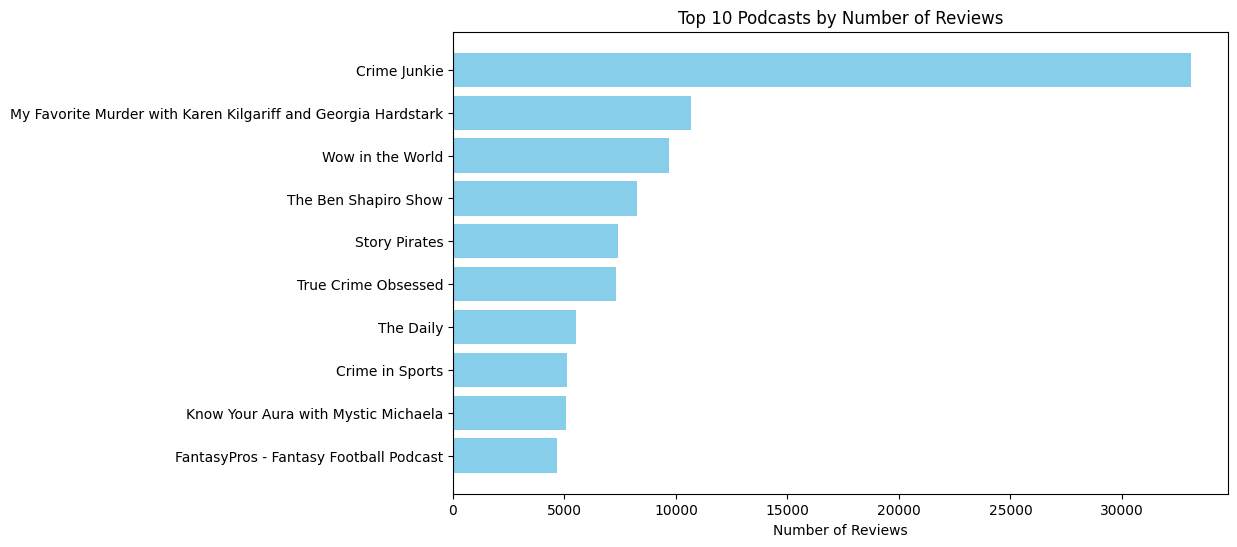

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(top_podcasts['podcast_title'], top_podcasts['review_count'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Podcasts by Number of Reviews')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()

Crime Junkie podcast has the highest number of reviews.

### Plotting the top podcasts by average rating

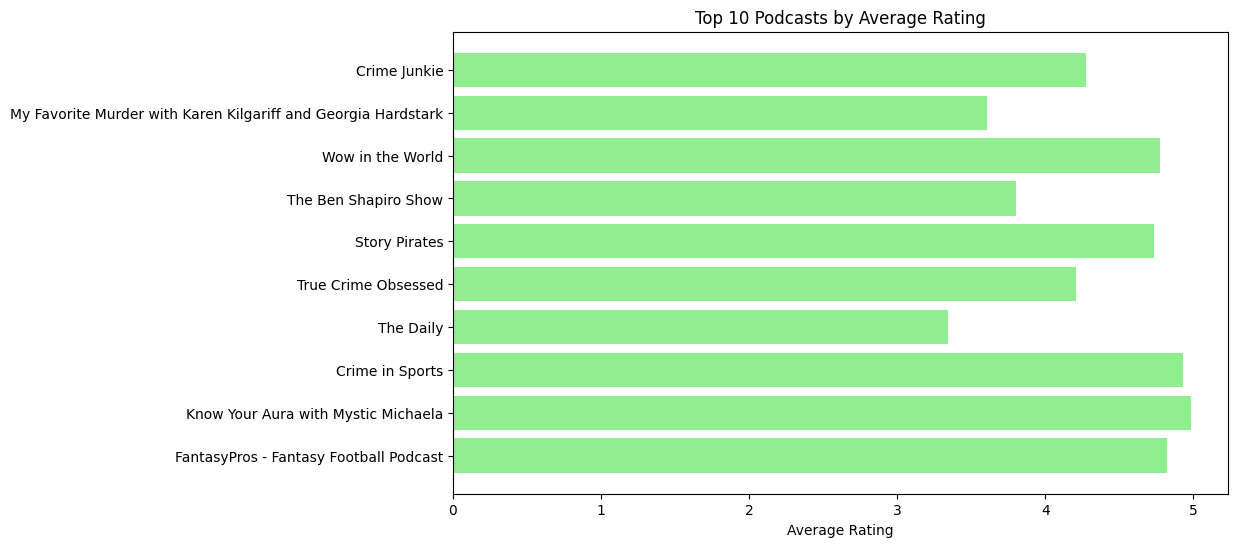

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(top_podcasts['podcast_title'], top_podcasts['average_rating'], color='lightgreen')
plt.xlabel('Average Rating')
plt.title('Top 10 Podcasts by Average Rating')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()

Know Your Aura with Mystic Michaela has the highest average rating followed by Crime in Sports.

### Creating a new dataframe for categories and ratings, calculating the average rating and review count for each category, sorting and get the top 10 categories by review count and average rating

In [19]:

categories_ratings = joined_df.assign(category=joined_df['all_categories'].str.split('; ')).explode('category')


category_metrics = categories_ratings.groupby('category').agg(
    average_rating=('rating', 'mean'),
    review_count=('rating', 'size')
).reset_index()


top_categories_by_reviews = category_metrics.nlargest(10, 'review_count')
top_categories_by_rating = category_metrics.nlargest(10, 'average_rating')


### Plotting the top categories by review count

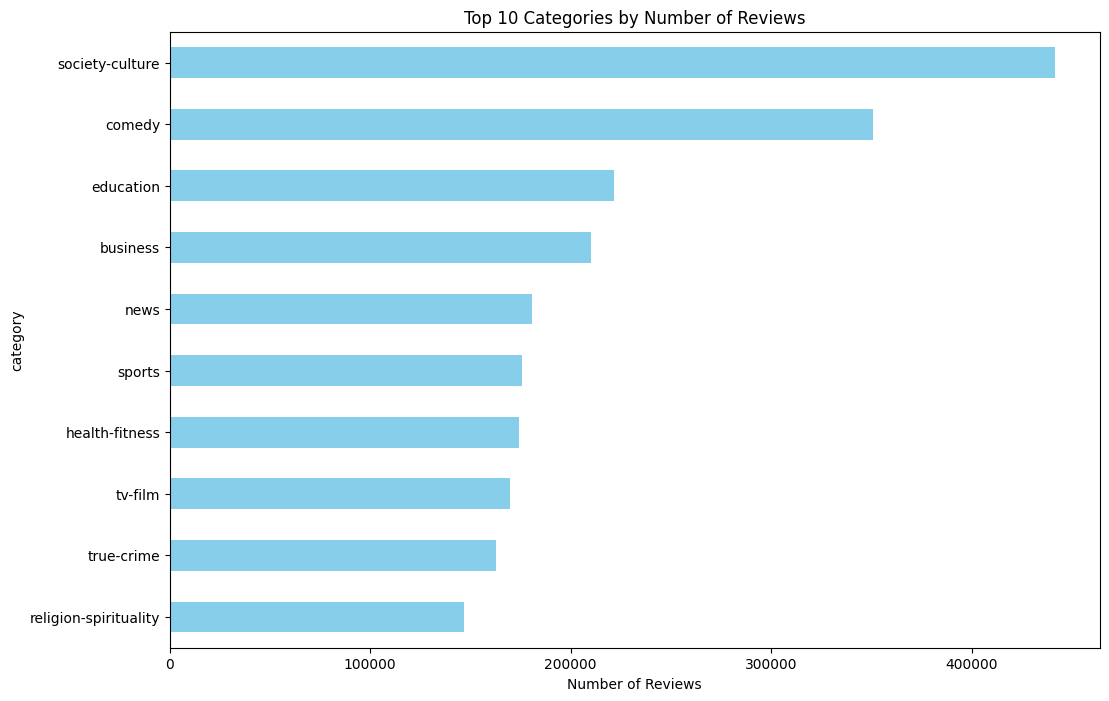

In [20]:
plt.figure(figsize=(12, 8))
top_categories_by_reviews.set_index('category')['review_count'].sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Categories by Number of Reviews')
plt.show()

Society-culture has the highest number of reviews followed by comedy.

### Plotting the top categories by average rating

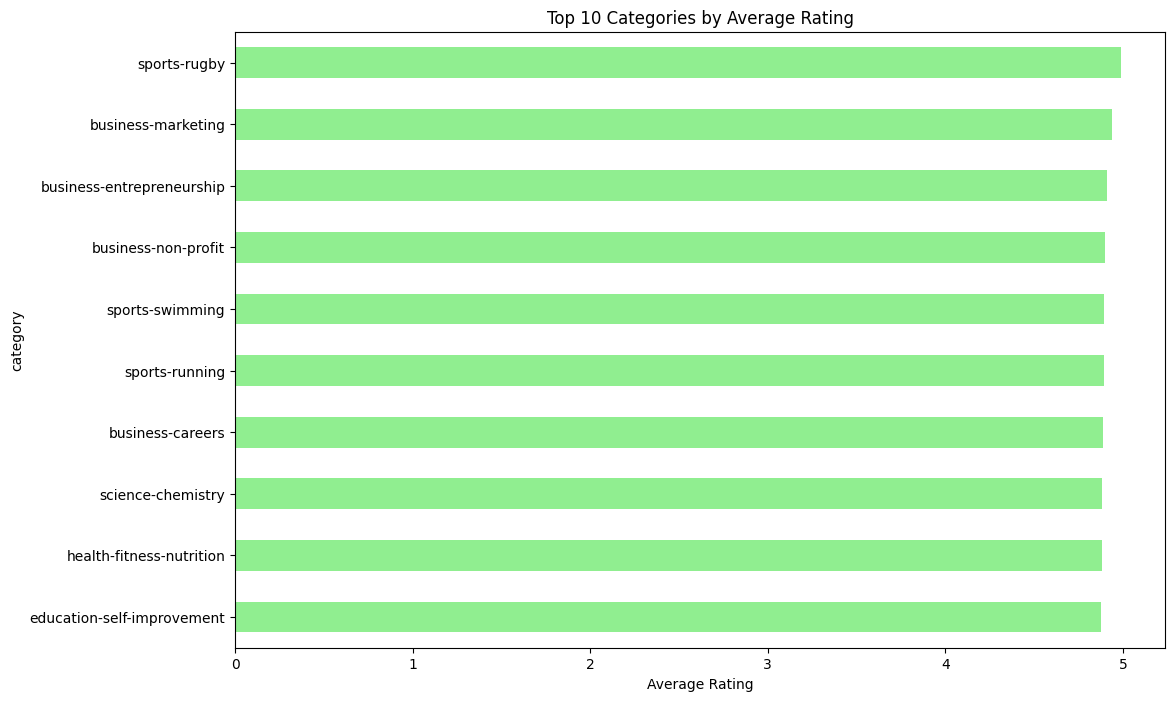

In [21]:
plt.figure(figsize=(12, 8))
top_categories_by_rating.set_index('category')['average_rating'].sort_values().plot(kind='barh', color='lightgreen')
plt.xlabel('Average Rating')
plt.title('Top 10 Categories by Average Rating')
plt.show()

Top 10 categories by average rating shows that the sport-rugby category has the highest rating but only by a small margin.

### Creating a Word Cloud - visualizing the most frequent words in the reviews

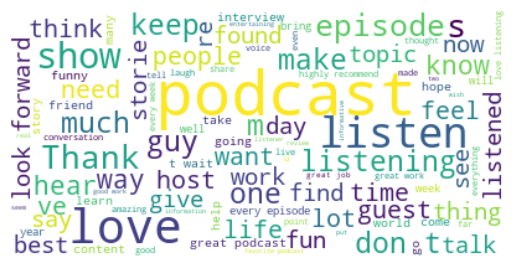

In [22]:
text = ' '.join(review for review in joined_df['content'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The word cloud of most used words in reviews shows that the most common words are: 'podcast', 'love', 'much', 'Thank', 'listen' etc.

### Sentiment analysis of top 10 podcasts by number of reviews

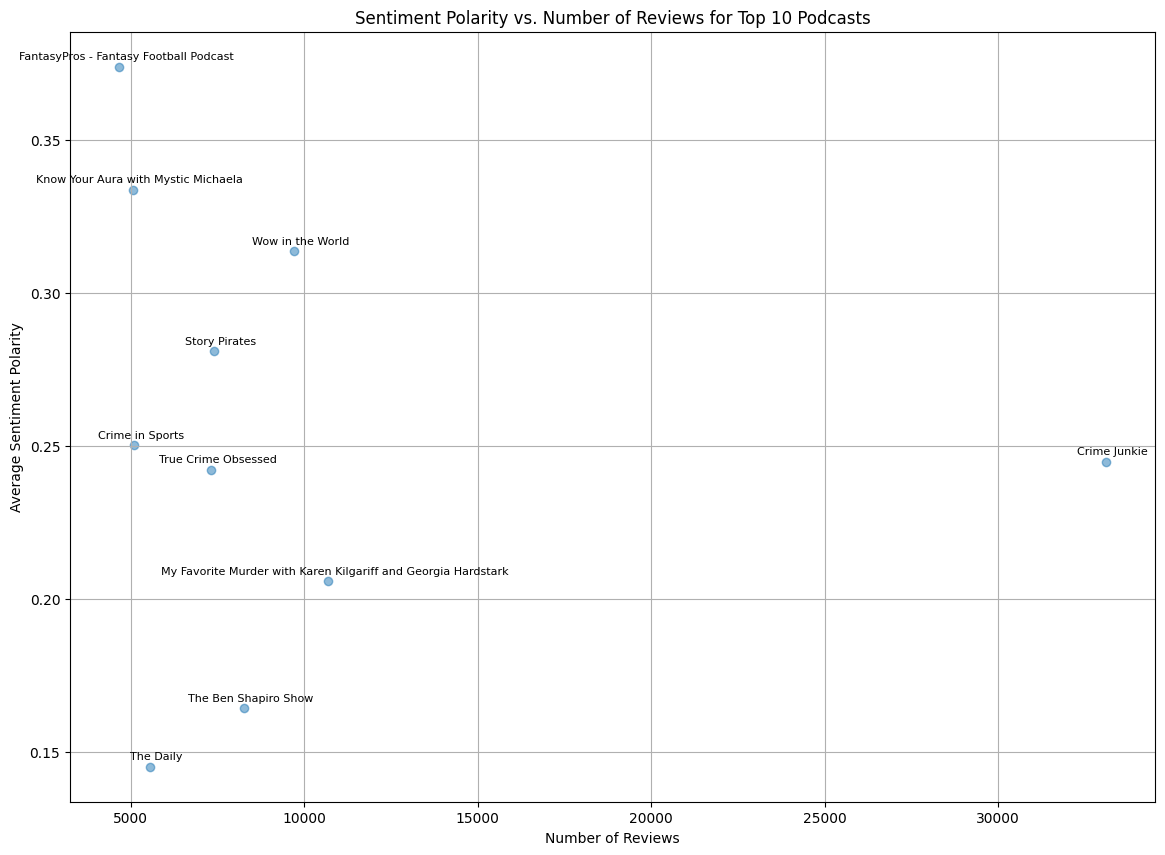

In [27]:
joined_df['sentiment'] = joined_df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

podcast_sentiment = joined_df.groupby('podcast_title').agg({
    'sentiment': 'mean',
    'review_title': 'count'
}).reset_index()

podcast_sentiment.rename(columns={'review_title': 'review_count'}, inplace=True)

top_podcasts_by_reviews = podcast_sentiment.nlargest(10, 'review_count')

plt.figure(figsize=(14, 10))
plt.scatter(top_podcasts_by_reviews['review_count'], top_podcasts_by_reviews['sentiment'], alpha=0.5)

for i, row in top_podcasts_by_reviews.iterrows():
    plt.annotate(row['podcast_title'], (row['review_count'], row['sentiment']), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)

plt.title('Sentiment Polarity vs. Number of Reviews for Top 10 Podcasts')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Sentiment Polarity')
plt.grid(True)
plt.show()

The closer the sentiment polarity is to 1 the reviews of the podcast are more positive. FantasyPros - Fantasy Football Podcast is has the highest sentiment polarity which indicates positive reviews but Crime Junkie podcast has the biggest number of reviews.

### Statistical inference

#### Hypothesis on Sentiment Polarity and Review Frequency

Podcasts with a higher frequency of reviews tend to have more positive sentiment polarity.
- This hypothesis suggests that podcasts that receive reviews more frequently might be more popular or engaging, leading to a more positive sentiment in the reviews.

In [28]:
correlation_coef, p_value = pearsonr(podcast_sentiment['review_count'], podcast_sentiment['sentiment'])

print(f"Pearson's correlation coefficient: {correlation_coef}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: -0.021735727579829393
P-value: 6.678393260108012e-13


The Pearson’s correlation coefficient is very close to zero, indicating a very weak negative correlation between sentiment polarity and review frequency. However, the extremely small p-value suggests that this correlation is statistically significant. This means that while there is a statistically significant relationship, the strength of the association is very weak, and higher review frequency does not necessarily correspond to more positive sentiment polarity.

#### Hypothesis on Rating Distribution Over Time

The distribution of ratings for podcasts changes over time, with newer podcasts receiving higher initial ratings.
- This hypothesis proposes that newer podcasts might receive a ‘honeymoon’ effect where initial listeners are more enthusiastic and likely to give higher ratings, which could change as the audience grows.

In [14]:
joined_df['created_at'] = pd.to_datetime(joined_df['created_at'])
joined_df['year'] = joined_df['created_at'].dt.year

average_rating_over_time = joined_df.groupby('year')['rating'].mean().reset_index()

X = average_rating_over_time['year'].values.reshape(-1, 1)
y = average_rating_over_time['rating'].values

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
print(f"Slope of the regression line: {slope}")

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

Slope of the regression line: -0.0035792865914927277
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.5540
Date:                Thu, 16 May 2024   Prob (F-statistic):              0.467
Time:                        17:59:38   Log-Likelihood:                 15.222
No. Observations:                  19   AIC:                            -26.44
Df Residuals:                      17   BIC:                            -24.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

c:\Users\kresi\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


The results of the statistical analysis for the second hypothesis are as follows:

The slope of the regression line is -0.0036. This negative slope indicates a very slight decrease in average ratings over time. However, the slope alone does not provide enough information to determine the statistical significance of this trend.

The p-value is 0.467, which is greater than the commonly used significance level of 0.05. This means that we fail to reject the null hypothesis, suggesting that there is not enough evidence to conclude that the slope of the regression line is significantly different from zero. In other words, the data does not provide strong evidence to support the hypothesis that newer podcasts receive higher initial ratings.

The R-squared value is 0.032, which is a measure of the proportion of the variance in the dependent variable (average rating) that is predictable from the independent variable (year). This low R-squared value indicates that only about 3.2% of the variability in the average rating can be explained by the year, suggesting that the year is not a strong predictor of the average rating.

The Durbin-Watson statistic is 0.397, which tests for the presence of autocorrelation (a relationship between values separated from each other by a given time lag) in the residuals (prediction errors). A value of 2.0 means there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from more than 2 to 4 indicate negative autocorrelation. Here, the value of 0.397 suggests a strong positive autocorrelation, which could be a concern for the reliability of the regression model.

In conclusion, based on the statistical analysis, there is not enough evidence to support the hypothesis that newer podcasts receive higher initial ratings. The data suggests that the distribution of ratings for podcasts does not significantly change over time. However, it’s important to note that these results are based on the available data and the specific statistical methods used, and other factors not included in the analysis could potentially influence the ratings of podcasts over time.

#### Hypothesis on Category Popularity and Sentiment

The most popular categories by review count will also have a higher average sentiment polarity compared to less popular categories.
- This hypothesis assumes that the popularity of a category, as measured by the number of reviews, is positively correlated with the sentiment of the reviews, indicating overall satisfaction within popular categories.

In [36]:
categories_ratings['sentiment'] = categories_ratings['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

category_sentiment = categories_ratings.groupby('category').agg({
    'sentiment': 'mean',
    'review_title': 'count'
}).reset_index()

category_sentiment.rename(columns={'review_title': 'review_count'}, inplace=True)

correlation_coef, p_value = pearsonr(category_sentiment['review_count'], category_sentiment['sentiment'])

print(f"Pearson's correlation coefficient: {correlation_coef}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: -0.1984993763107235
P-value: 0.037632936767080793


The Pearson’s correlation coefficient indicates a weak negative correlation between category popularity and sentiment polarity. The p-value is less than 0.05, which suggests that the correlation is statistically significant. This means that more popular categories, as measured by the number of reviews, tend to have a slightly lower average sentiment polarity, contrary to the hypothesis.

### Suggestions for Analysis Improvements:

- The current analysis primarily focuses on the number of reviews, average rating, and sentiment polarity. Incorporating additional variables such as podcast duration, host details, guest appearances, etc., could provide a more comprehensive understanding of the factors influencing podcast popularity and ratings.

- The review text could be further analyzed to identify common themes or topics using techniques like topic modeling or named entity recognition.

- Exploring relationships between multiple variables simultaneously could reveal more complex patterns and interactions.

### Conclusion:

The analysis provided valuable insights into the podcast data, revealing the top podcasts and categories by review count and average rating. However, the hypotheses tested did not find strong evidence to support the claims that higher review frequency corresponds to more positive sentiment polarity, newer podcasts receive higher initial ratings, or more popular categories have a higher average sentiment polarity. These findings highlight the complexity of podcast ratings and popularity, which are likely influenced by a multitude of factors beyond those included in this analysis. Further research and more sophisticated analytical techniques could provide additional insights into these relationships.